<a href="https://colab.research.google.com/github/Zahra-Nahardani/WindEnergy-TimeSeries-Project/blob/main/WindEnergy-TimeSeries-Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

****************************************************************************
# **Data Description**

The dataset contains daily measurements of weather conditions and wind power generation recorded in Germany from 2017 to 2019. It includes key variables such as temperature, wind capacity, and wind energy production. These data points provide insights into how meteorological factors influence wind power generation over time.

The primary goal of this project is to analyze and forecast wind power generation for December 2019. This involves data preprocessing, exploratory data analysis, time series pattern identification, and predictive modeling.

'WindEnergy' dataset consists of 1,094 entries with four columns:


1.   *utc_timestamp:* A timestamp indicating the time of measurement.
2.   *wind_generation_actual:* The actual wind energy generated.
3.   *wind_capacity:* The total wind energy capacity.
4.   *temperature:* The temperature recorded at the given time.
****************************************************************************

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
!pip install statsforecast
from statsforecast.models import SeasonalNaive

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from numpy.fft import fft, ifft
from statsmodels.tsa.holtwinters import ExponentialSmoothing
! pip install pmdarima
from pmdarima import auto_arima
!pip install pmdarima --no-cache-dir
!pip show pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 5.8 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.5 MB/s eta 0:00:00
Name: pmdarima
Version: 2.0.4
Summary: Python's forecast::auto.arima equivalent
Home-page: http://alkaline-ml.com/pmdarima
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: Cython, joblib, numpy, packaging, pandas, scikit-learn, scipy, setuptools, statsmodels, urllib3
Required-by: 


# **Load Data**

In [ ]:
data = pd.read_csv('WindEnergy.csv', parse_dates=['utc_timestamp'], index_col='utc_timestamp')

In [ ]:
# Showing the first five rows of the dataset
display(data.head())

,wind_generation_actual,wind_capacity,temperature
utc_timestamp,,,
2017-01-01 00:00:00+00:00,291760.0,37149.130,-2.117
2017-01-02 00:00:00+00:00,295097.0,37152.125,-1.154
2017-01-03 00:00:00+00:00,666170.0,37155.208,-0.239
2017-01-04 00:00:00+00:00,686581.0,37160.125,0.620
2017-01-05 00:00:00+00:00,261759.0,37163.542,-3.908


# **Data Preprocessing**

In [ ]:
# removing timpestamp component
data.index = pd.to_datetime(data.index.date, format='%Y-%m-%d', errors='coerce')
data.index.name = 'date'

In [ ]:
print(data.head(3))
print(data.tail(3))

            wind_generation_actual  wind_capacity  temperature
date                                                          
2017-01-01                291760.0      37149.130       -2.117
2017-01-02                295097.0      37152.125       -1.154
2017-01-03                666170.0      37155.208       -0.239
            wind_generation_actual  wind_capacity  temperature
date                                                          
2019-12-28                159126.0      50427.292       -1.441
2019-12-29                349839.0      50434.750       -1.314
2019-12-30                639343.0      50452.000        0.542


In [ ]:
data.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2019-12-21', '2019-12-22', '2019-12-23', '2019-12-24',
               '2019-12-25', '2019-12-26', '2019-12-27', '2019-12-28',
               '2019-12-29', '2019-12-30'],
              dtype='datetime64[ns]', name='date', length=1094, freq=None)

In [ ]:
# Checking for missing values in each column
missing_values = data.isnull().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 wind_generation_actual    0
wind_capacity             0
temperature               0
dtype: int64


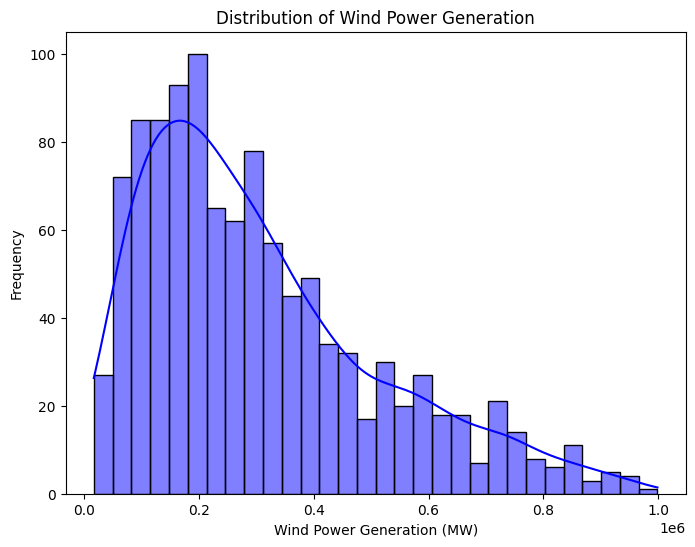

In [ ]:
# Histogram for checking the distribution
plt.figure(figsize=(8,6))
sns.histplot(data['wind_generation_actual'], bins=30, kde=True, color='blue')
plt.xlabel("Wind Power Generation (MW)")
plt.ylabel("Frequency")
plt.title("Distribution of Wind Power Generation")
plt.show()

****************************************************************************
The data is right-skewed, with most values concentrated at lower levels and a long tail indicating occasional high-generation days. The distribution is not normal, suggesting seasonal variations and potential outliers affecting forecasting models.
****************************************************************************

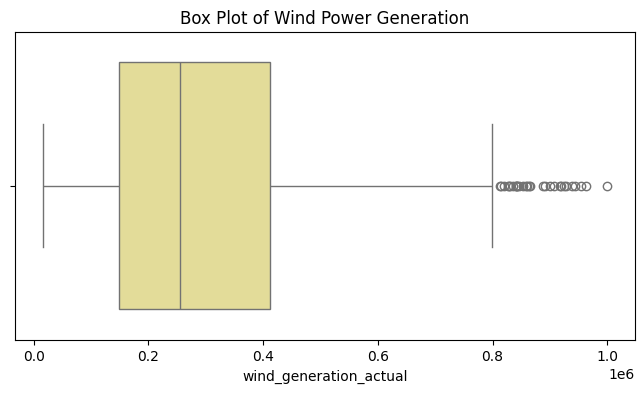

In [ ]:
# checking for outliers
plt.figure(figsize=(8,4))
sns.boxplot(x=data['wind_generation_actual'], color='khaki')
plt.title("Box Plot of Wind Power Generation")
plt.show()

****************************************************************************
There are several outliers on the higher end, meaning some days had unusually high wind generation. These could be valid peaks (e.g., storms) or potential data errors.
****************************************************************************

In [ ]:
Q1 = data['wind_generation_actual'].quantile(0.25)
Q3 = data['wind_generation_actual'].quantile(0.75)
IQR = Q3 - Q1

outliers = data[(data['wind_generation_actual'] < (Q1 - 1.5 * IQR)) | (data['wind_generation_actual'] > (Q3 + 1.5 * IQR))]
print(outliers)

            wind_generation_actual  wind_capacity  temperature
date                                                          
2017-02-22                826273.0      37738.000        7.353
2017-10-28                819820.0      41565.250        8.441
2017-12-24                812420.0      42640.000        5.674
2018-01-03                937882.0      42863.000        5.367
2018-01-28                841002.0      42991.500        5.433
2018-01-29                899632.0      43026.958        6.967
2018-10-23                864205.0      48193.250        8.852
2018-12-08                998899.0      48607.000        5.803
2018-12-09                888048.0      48607.417        5.918
2018-12-10                842063.0      48618.125        3.170
2019-01-01                815236.0      48974.000        4.291
2019-01-08                962242.0      48981.333        3.388
2019-01-13                907162.0      48989.292        4.613
2019-01-14                829824.0      48996.000      

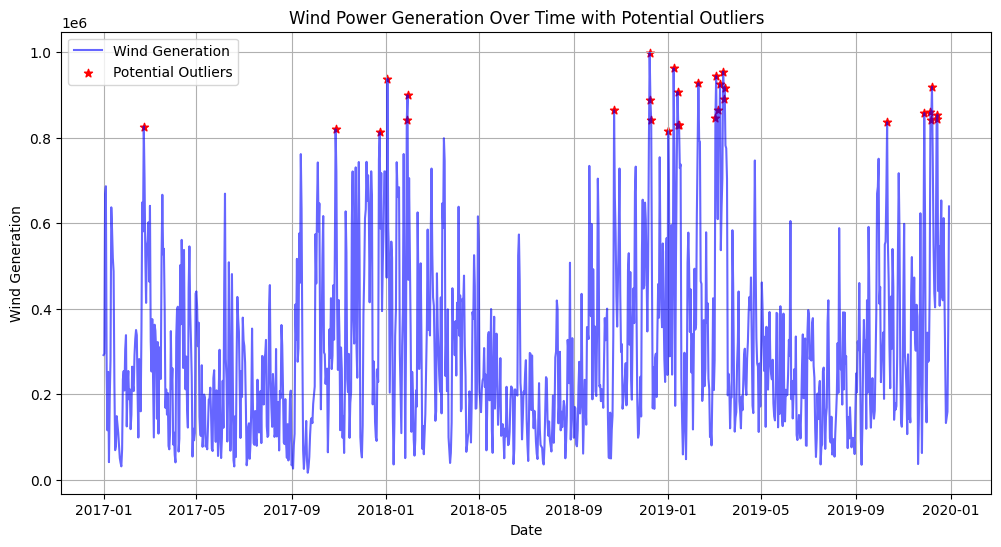

In [ ]:
# Visualizing extreme wind generation values over time
plt.figure(figsize=(12,6))
plt.plot(data.index, data['wind_generation_actual'], label='Wind Generation', color='blue', alpha=0.6)

plt.scatter(outliers.index, outliers['wind_generation_actual'], color='red', label='Potential Outliers', marker='*')

plt.title("Wind Power Generation Over Time with Potential Outliers")
plt.xlabel("Date")
plt.ylabel("Wind Generation")
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

****************************************************************************
Some of the outliers appear in clusters, especially in the winter months, and a few extreme values stand alone, which might be data errors. So, we can leave the data unchanged.
****************************************************************************

# **Exploratory Analysis**

In [ ]:
# Display dataset details
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1094 entries, 2017-01-01 to 2019-12-30
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   wind_generation_actual  1094 non-null   float64
 1   wind_capacity           1094 non-null   float64
 2   temperature             1094 non-null   float64
dtypes: float64(3)
memory usage: 34.2 KB


In [ ]:
# Providing summary statistics for numerical columns
data.describe()

,wind_generation_actual,wind_capacity,temperature
count,1094.000000,1094.000000,1094.000000
mean,305819.767824,45066.022789,10.050167
std,205728.857915,4315.838061,7.739158
min,16482.000000,37149.130000,-9.363000
25%,148552.750000,41447.937500,3.577250
50%,254332.500000,46073.000000,10.046500
75%,412570.500000,49203.000000,16.566000
max,998899.000000,50452.000000,28.241000


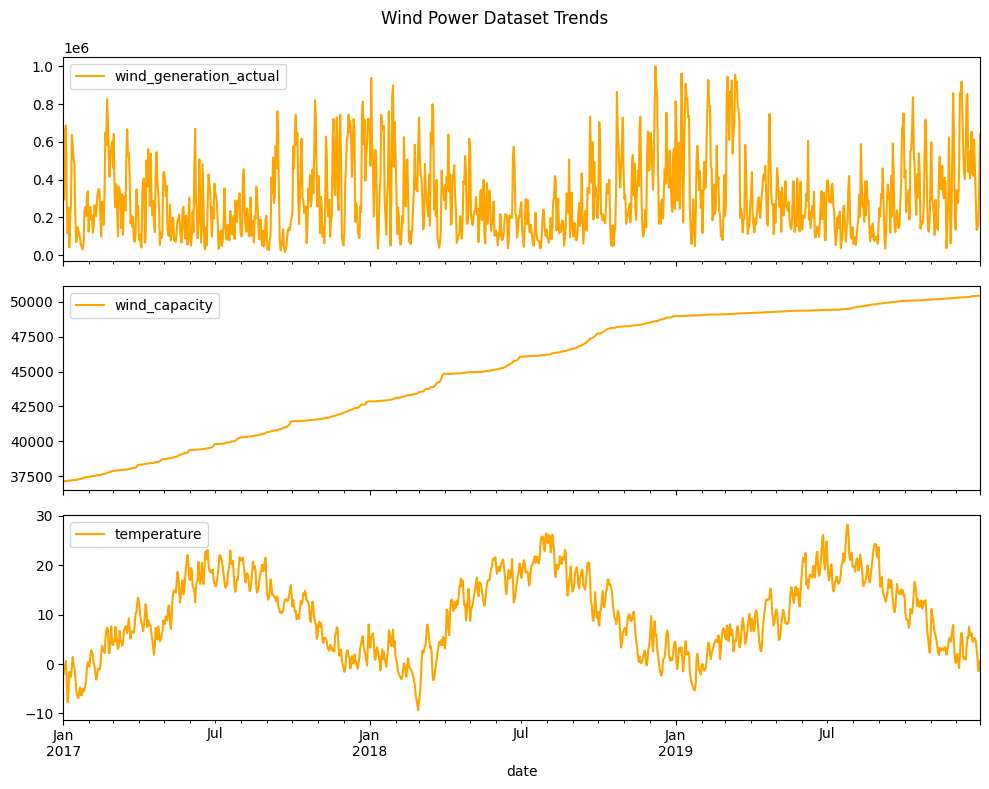

In [ ]:
#visualizing variables' changes over time
data.plot(subplots=True, figsize=(10, 8), title='Wind Power Dataset Trends', color='orange')
plt.tight_layout()
plt.show()

****************************************************************************
**Wind Generation plot:**
The data appears highly variable with frequent spikes and troughs, indicating the dynamic nature of wind energy production.

**wind Capacity plot:**
This plot shows the wind capacity over time, which seems to be steadily increasing. This indicates infrastructure development or capacity upgrades over the period.

**Temperature plot:**
This plot illustrates temperature fluctuations, following a clear seasonal pattern. Peaks during summer and troughs during winter align with expected seasonal temperature changes.
****************************************************************************


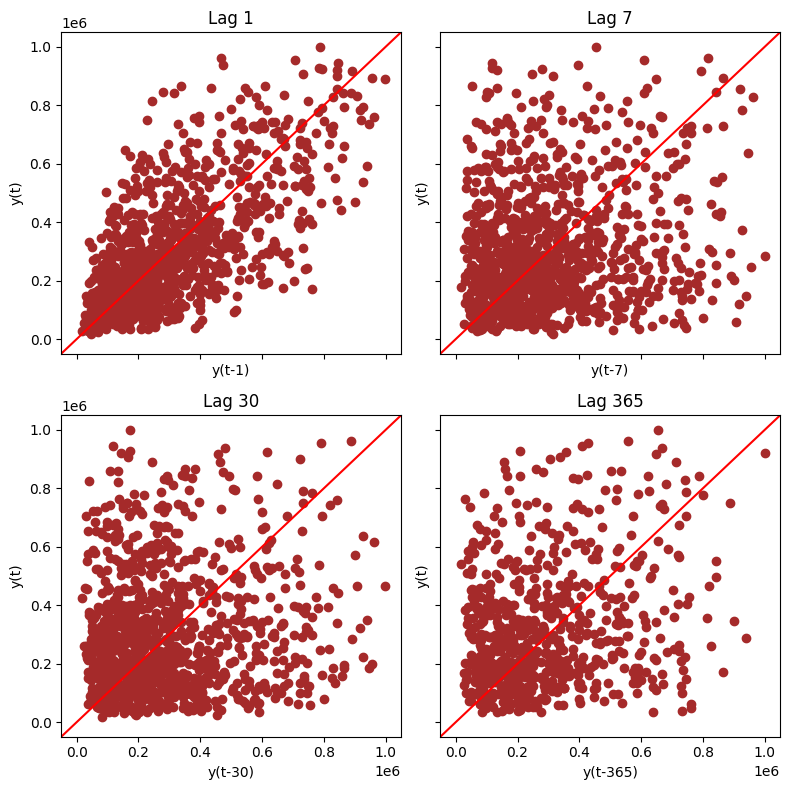

In [ ]:
# lag plot
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 8))

lags = [1, 7, 30, 365]
for i, lag in enumerate(lags):
    ax = axes.flat[i]
    lag_plot(data['wind_generation_actual'], lag=lag, ax=ax, c='brown')
    ax.set_xlabel(f'y(t-{lag})')
    ax.set_ylabel('y(t)')
    ax.set_title(f'Lag {lag}')
    pt = (350, 350)
    ax.axline(pt, slope=1, color='red')

plt.tight_layout()
plt.show()

****************************************************************************
*  Short-term correlation (Lag 1 & Lag 7) is stronger, meaning wind power generation is more predictable on a daily and weekly basis.
*  Long-term correlation (Lag 30 & Lag 365) weakens, indicating higher variability and seasonal effects in monthly and yearly trends.
*  Wind generation patterns fluctuate over time, making short-term forecasting more reliable than long-term predictions.
****************************************************************************

<ipython-input-16-cb82defd6a21>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data['wind_generation_actual'].resample('M').mean()


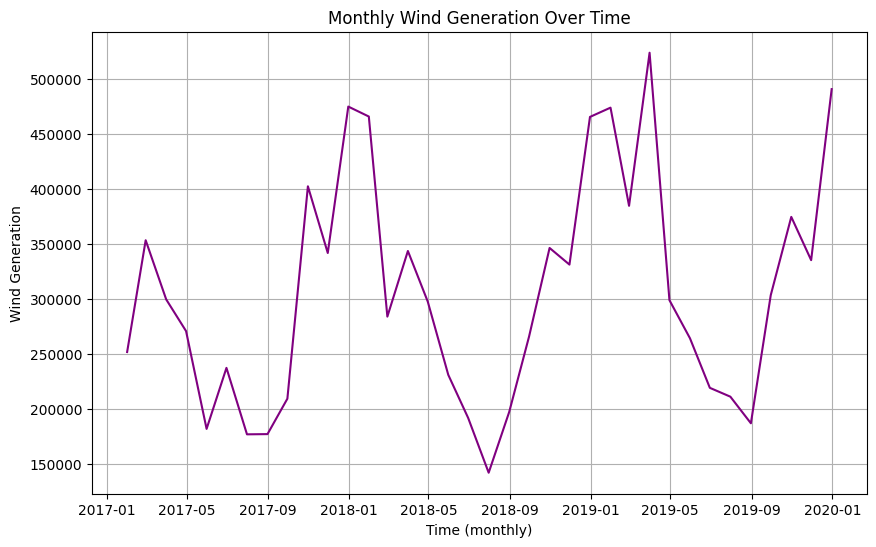

In [ ]:
# monthly resampling

plt.figure(figsize=(10,6))
monthly_data = data['wind_generation_actual'].resample('M').mean()
plt.plot(monthly_data, color='purple')
plt.xlabel("Time (monthly)")
plt.ylabel("Wind Generation")
plt.title("Monthly Wind Generation Over Time")
plt.grid(True)
plt.show()

****************************************************************************

*   The wind generation peaks during winter months (December–January).
*   The plot confirms a seasonal trend in wind energy production.
*   A weekly resampling (instead of monthly) might give more granularity and details about short-term fluctuations.
****************************************************************************



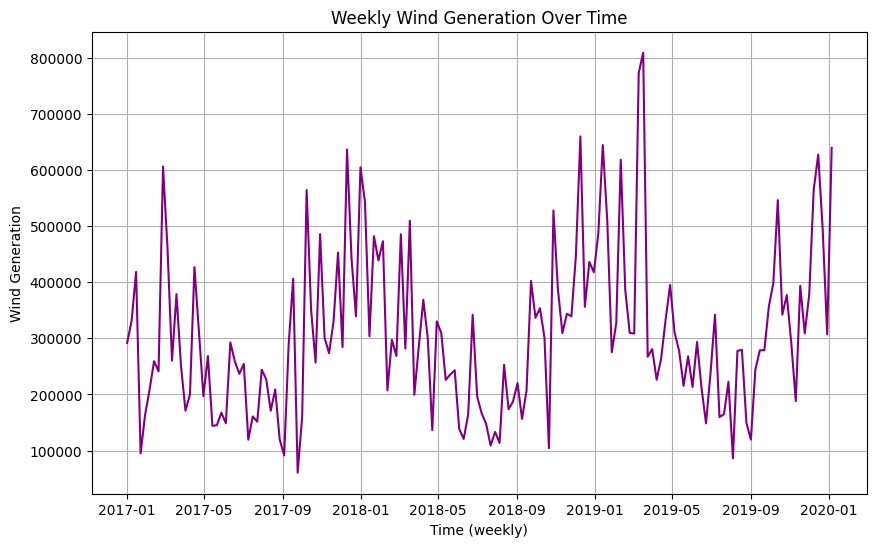

In [ ]:
# weekly resampling
plt.figure(figsize=(10,6))
weekly_data = data['wind_generation_actual'].resample('W').mean()
plt.plot(weekly_data, color='purple')
plt.xlabel("Time (weekly)")
plt.ylabel("Wind Generation")
plt.title("Weekly Wind Generation Over Time")
plt.grid(True)
plt.show()

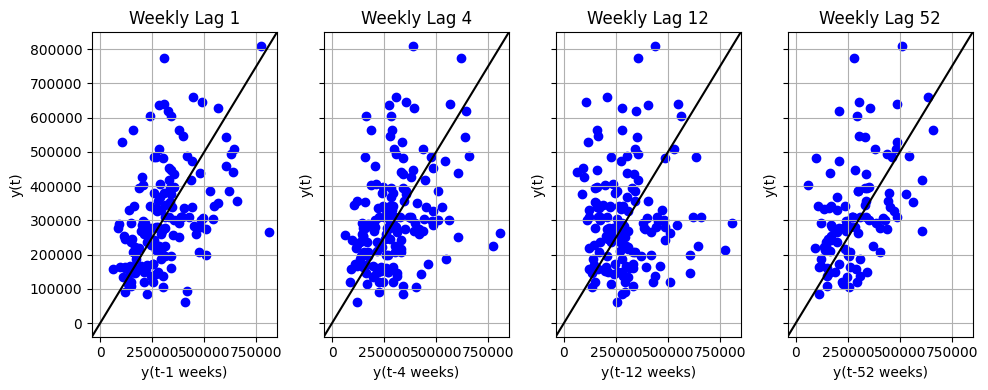

In [ ]:
# weekly lag plot
weekly_lags = [1, 4, 12, 52]

fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(10, 4))

for i, lag in enumerate(weekly_lags):
    ax = axes.flat[i]
    lag_plot(weekly_data, lag=lag, ax=ax, c='blue')
    ax.set_xlabel(f'y(t-{lag} weeks)')
    ax.set_ylabel('y(t)')
    ax.set_title(f'Weekly Lag {lag}')
    ax.axline((350, 350), slope=1, color='black')
    ax.grid(True)

plt.tight_layout()
plt.show()

****************************************************************************
*  Short-term weekly trends (Lag 1) are more predictable.
*   Monthly and seasonal trends (Lags 4 & 12) show weaker correlation, suggesting high variability.
*  Yearly trends (Lag 52) do not follow a clear pattern, indicating that annual wind generation is not highly repetitive.
*  So, in the wind power forecasting models should focus on short-term trends rather than long-term seasonality.
****************************************************************************

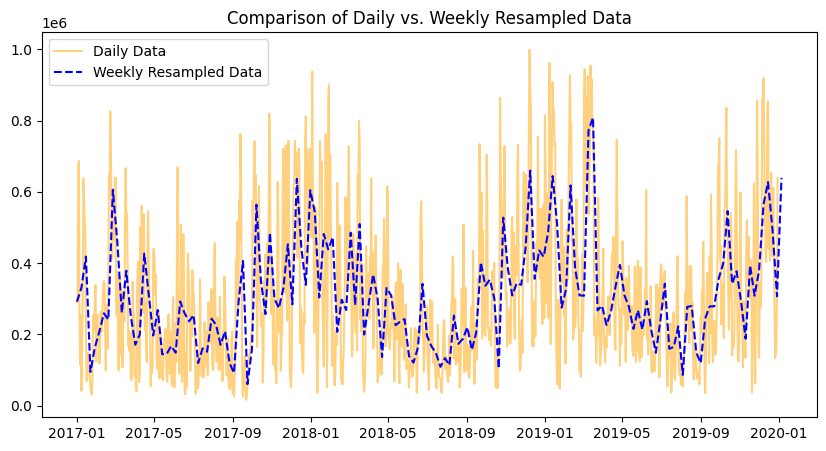

In [ ]:
# Comparison of Daily vs. Weekly Resampled Data
plt.figure(figsize=(10, 5))
plt.plot(data['wind_generation_actual'], label="Daily Data", alpha=0.5, color='orange')
plt.plot(weekly_data, label="Weekly Resampled Data", color='blue', linestyle='--')
plt.title("Comparison of Daily vs. Weekly Resampled Data")
plt.legend()
plt.show()

In [ ]:
# Pearson Correlation
correlation_matrix = data.corr(method='pearson')
print("\nCorrelation Matrix:\n", correlation_matrix)


Correlation Matrix:
                         wind_generation_actual  wind_capacity  temperature
wind_generation_actual                1.000000       0.127708    -0.325831
wind_capacity                         0.127708       1.000000     0.112132
temperature                          -0.325831       0.112132     1.000000


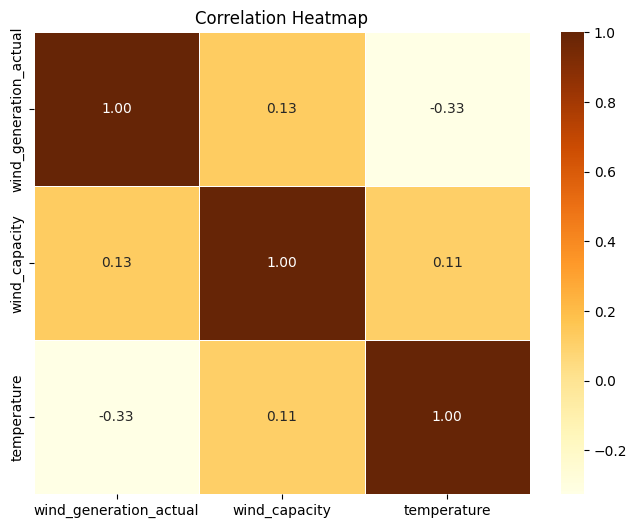

In [ ]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='YlOrBr', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

****************************************************************************

The correlation matrix shows the Pearson correlation coefficients between the three numerical variables.

Wind Generation vs Temperature (moderate negative correlation).

Wind Capacity vs Wind Generation (weak positive correlation).

Wind Capacity vs Temperature (almost no correlation).
****************************************************************************

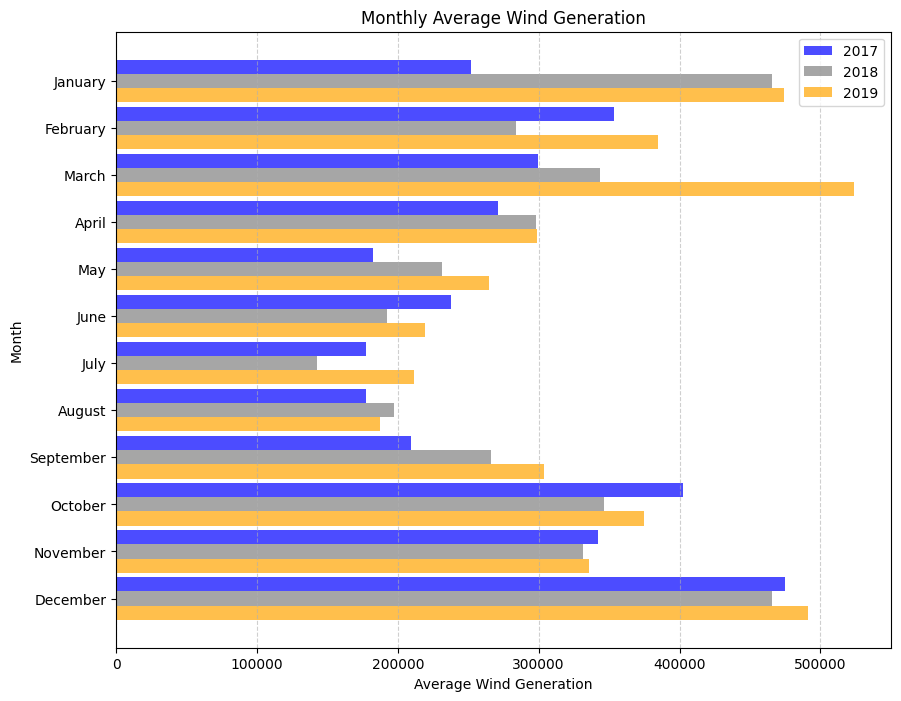

In [ ]:
data2 = data.copy()

data2['year'] = data.index.year
data2['month'] = data.index.month

monthly_avg = data2.groupby(['year', 'month'])['wind_generation_actual'].mean().unstack(level=0)

months = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]


fig, ax = plt.subplots(figsize=(10, 8))
bar_width = 0.3


y_pos = range(len(months))

ax.barh(y_pos, monthly_avg[2017], height=bar_width, label="2017", color='blue', alpha=0.7)
ax.barh([y + bar_width for y in y_pos], monthly_avg[2018], height=bar_width, label="2018", color='gray', alpha=0.7)
ax.barh([y + 2 * bar_width for y in y_pos], monthly_avg[2019], height=bar_width, label="2019", color='orange', alpha=0.7)

ax.set_yticks([y + bar_width for y in y_pos])
ax.set_yticklabels(months)
ax.set_xlabel("Average Wind Generation")
ax.set_ylabel("Month")
ax.set_title("Monthly Average Wind Generation")
ax.legend()

plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle="--", alpha=0.6)
plt.show()

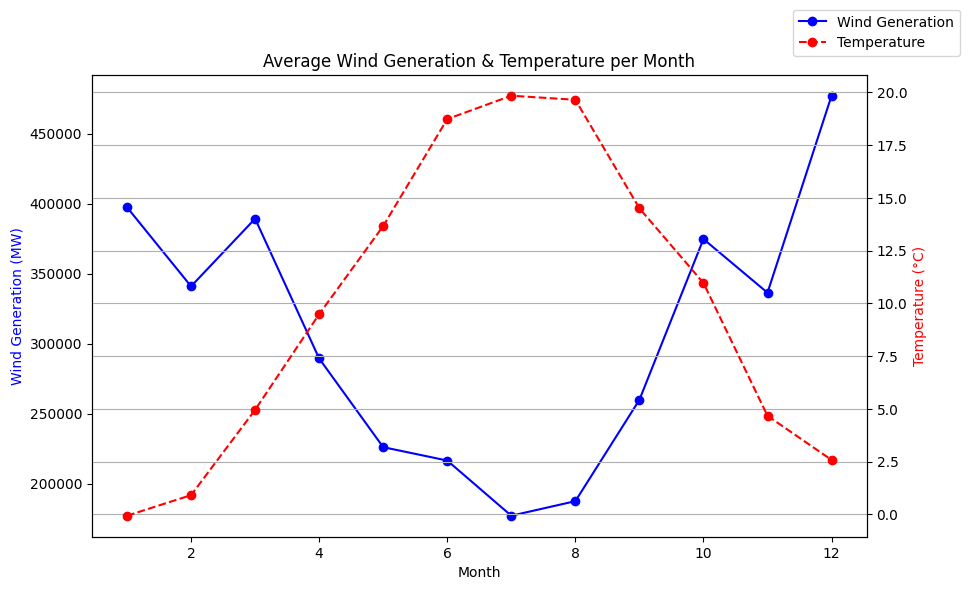

In [ ]:
# Compute monthly averages
monthly_avg = data2.groupby('month')[['wind_generation_actual', 'temperature']].mean()

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_xlabel("Month")
ax1.set_ylabel("Wind Generation (MW)", color='blue')
ax1.plot(monthly_avg.index, monthly_avg['wind_generation_actual'], marker='o', color='blue', label='Wind Generation')

ax2 = ax1.twinx()
ax2.set_ylabel("Temperature (°C)", color='red')
ax2.plot(monthly_avg.index, monthly_avg['temperature'], marker='o', color='red', linestyle='dashed', label='Temperature')

plt.title("Average Wind Generation & Temperature per Month")
fig.legend(loc="upper right", bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

****************************************************************************
This plot shows the inverse correlation between wind power and temperature that confirms findings from the Pearson correlation analysis (-0.325).
****************************************************************************

# **Checking for the seasonality**

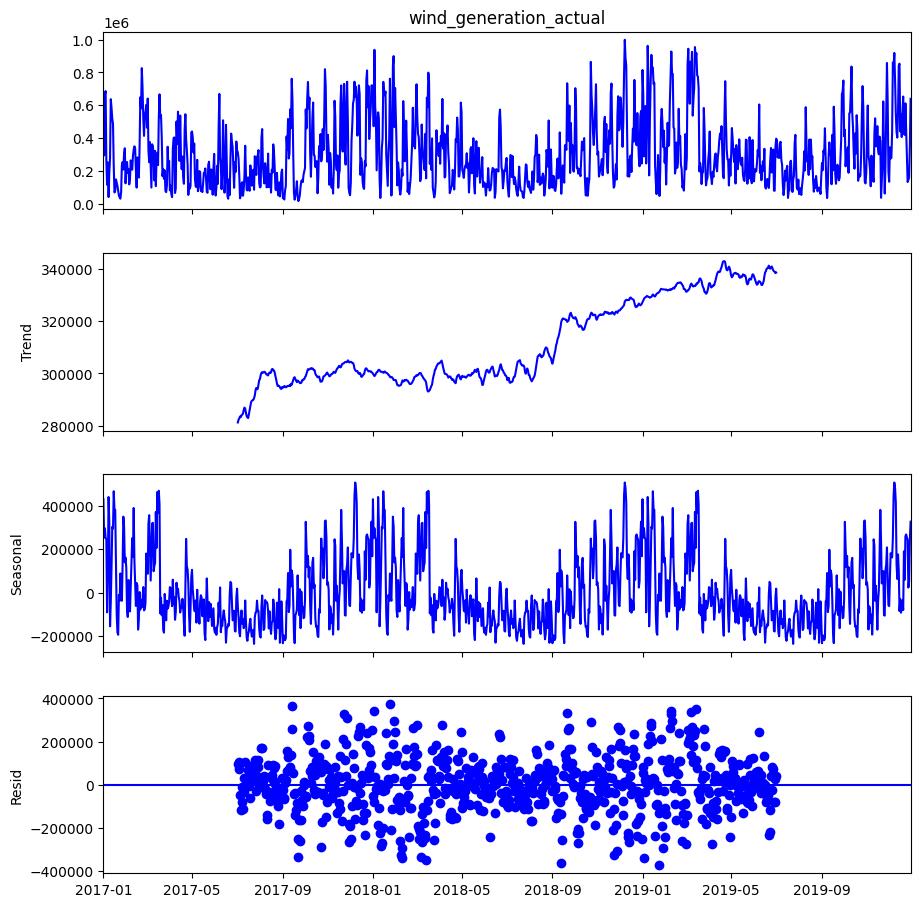

In [ ]:
# Decompose the time series into trend, seasonal, and residual components.
series = data['wind_generation_actual']
decomposition = seasonal_decompose(series, model='additive', period=365)
fig = decomposition.plot()
fig.set_size_inches(10, 10)
for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color('blue')
plt.show()


****************************************************************************
*   There is a gradual upward trend in wind power generation.
*   The seasonal pattern is strong, with repeated fluctuations.
*   Residuals are relatively balanced, meaning the decomposition effectively captures the key patterns.
****************************************************************************


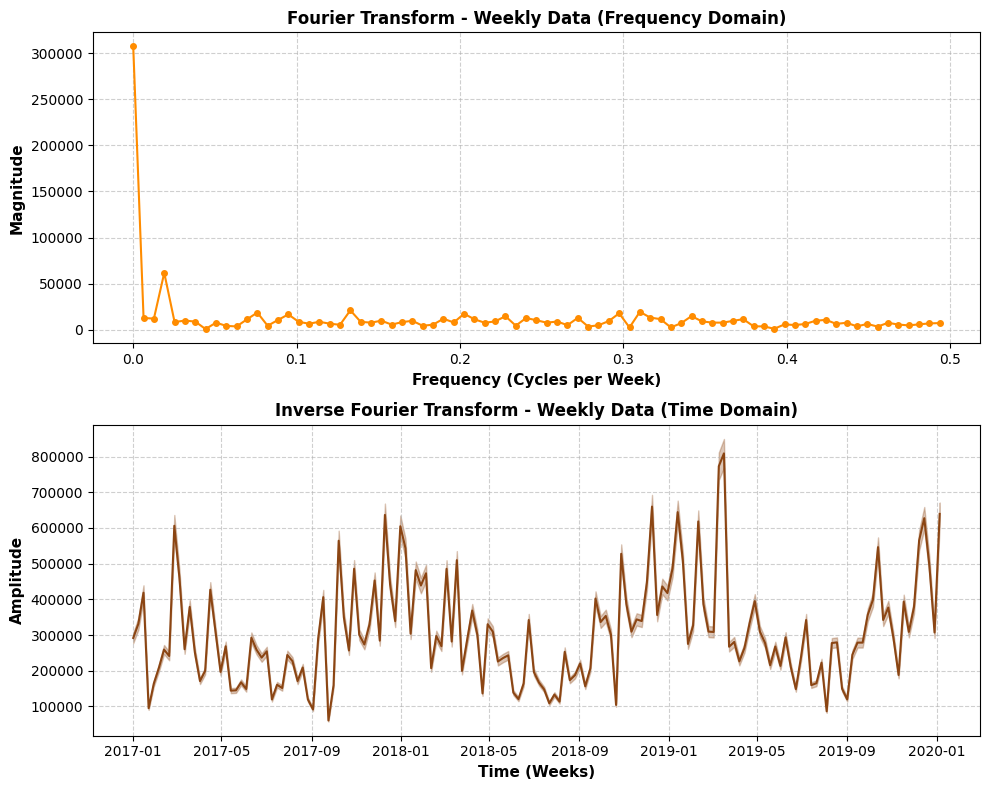

In [ ]:
# Fourier and Inverse Fourier Transform - Weekly Data
Fs = 1

# Compute FFT
X_freq = fft(weekly_data)
N = len(weekly_data)

freq_values = np.fft.fftfreq(N, d=1)[:N // 2]  # d=1 means weekly frequency


fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].plot(freq_values, np.abs(X_freq[:N // 2]) / N, color='darkorange', linestyle='-', marker='o', markersize=4)
axes[0].set_xlabel('Frequency (Cycles per Week)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Magnitude', fontsize=11, fontweight='bold')
axes[0].set_title("Fourier Transform - Weekly Data (Frequency Domain)", fontsize=12, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Compute Inverse FFT
reconstructed_signal = np.real(ifft(X_freq))

time_weeks = weekly_data.index

axes[1].plot(time_weeks, reconstructed_signal, color='saddlebrown', linestyle='-')
axes[1].fill_between(time_weeks, reconstructed_signal - 0.05 * reconstructed_signal,
                     reconstructed_signal + 0.05 * reconstructed_signal, color='saddlebrown', alpha=0.3)
axes[1].set_xlabel('Time (Weeks)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Amplitude', fontsize=11, fontweight='bold')
axes[1].set_title("Inverse Fourier Transform - Weekly Data (Time Domain)", fontsize=12, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

****************************************************************************
*  Wind power generation follows a long-term increasing trend, meaning it's gradually rising over time.
*  There are seasonal patterns, but they are not as strong as the long-term trend.
*  The Fourier Transform successfully captures these trends, and the reconstructed signal closely matches real-world wind variations.
****************************************************************************

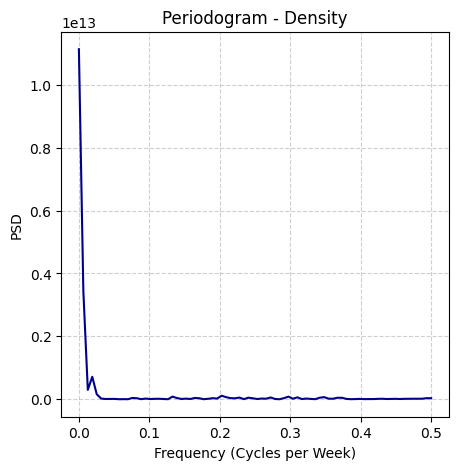

In [ ]:
# Power Spectral Density (PSD)
import scipy.signal as signal

Fs = 1
window_type = 'triang'

# Compute PSD using Periodogram
f_per_density, Pxx_per_density = signal.periodogram(weekly_data, Fs, detrend=False, window=window_type,
                                                    nfft=None, return_onesided=True, scaling='density')

fig1, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(f_per_density, Pxx_per_density, color='darkblue', linestyle='-')
ax.set_title('Periodogram - Density', fontsize=12)
ax.set(xlabel='Frequency (Cycles per Week)', ylabel='PSD')
ax.grid(True, linestyle='--', alpha=0.6)

****************************************************************************
As seen in the FFT and PSD results, wind power generation is mainly influenced by a long-term increasing trend, rather than a strict yearly seasonality. While some seasonal variations may exist, they are much weaker compared to the overall trend.
****************************************************************************

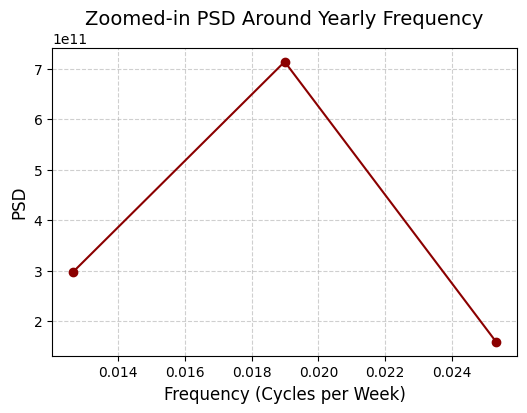

Dominant frequency in yearly range: 0.0190 cycles per week
Corresponding PSD value: 7.14e+11


In [ ]:
# Plot the zoomed-in PSD around the yearly frequency

yearly_frequency = 1 / 52  # 1 cycle per year (since data is weekly)

freq_range = (f_per_density >= yearly_frequency - 0.01) & (f_per_density <= yearly_frequency + 0.01)
filtered_frequencies = f_per_density[freq_range]
filtered_psd_values = Pxx_per_density[freq_range]

plt.figure(figsize=(6, 4))
plt.plot(filtered_frequencies, filtered_psd_values, color='darkred', marker='o', linestyle='-')
plt.xlabel("Frequency (Cycles per Week)", fontsize=12)
plt.ylabel("PSD", fontsize=12)
plt.title("Zoomed-in PSD Around Yearly Frequency", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

max_psd_index = np.argmax(filtered_psd_values)
dominant_frequency = filtered_frequencies[max_psd_index]
dominant_psd_value = filtered_psd_values[max_psd_index]

print(f"Dominant frequency in yearly range: {dominant_frequency:.4f} cycles per week")
print(f"Corresponding PSD value: {dominant_psd_value:.2e}")

****************************************************************************
This plot focuses on the frequency range around 1 cycle per year (0.019 cycles per week) and shows a clear peak at 0.019 cycles per week, confirming a yearly periodic pattern in wind power generation. So, yearly seasonality is confirmed as wind generation peaks and dips follow a 1-year cycle.
****************************************************************************

# **Checking for the stationarity**

In [ ]:
# ADF test
def adf_test(data):
  adf_test = adfuller(data,autolag='AIC')
  print('ADF Statistic:', adf_test[0])
  print('p-value: ', adf_test[1])
  print('Critical Values:')
  for key, value in adf_test[4].items():
      print(key, value)

  if adf_test[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is non-stationary')

adf_test(weekly_data)

ADF Statistic: -2.1256582182920196
p-value:  0.2343232327316201
Critical Values:
1% -3.474120870218417
5% -2.880749791423677
10% -2.5770126333102494
We cannot reject the null hypothesis (H0) --> data is non-stationary


****************************************************************************
* The ADF test result suggest that our weekly resampled wind power data is non-stationary and requires differencing.
****************************************************************************

In [ ]:
# KPSS test
def kpss_test(data):
  kpss_out = kpss(data,regression='c', nlags='auto', store=True)
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is not trend stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')

kpss_test(weekly_data)

KPSS Statistic: 0.20710233468702913
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


<ipython-input-29-647fc49edd05>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_out = kpss(data,regression='c', nlags='auto', store=True)


****************************************************************************
* The KPSS test result suggest that the data may be stationary in trend but not fully stationary, meaning differencing is still needed.
****************************************************************************

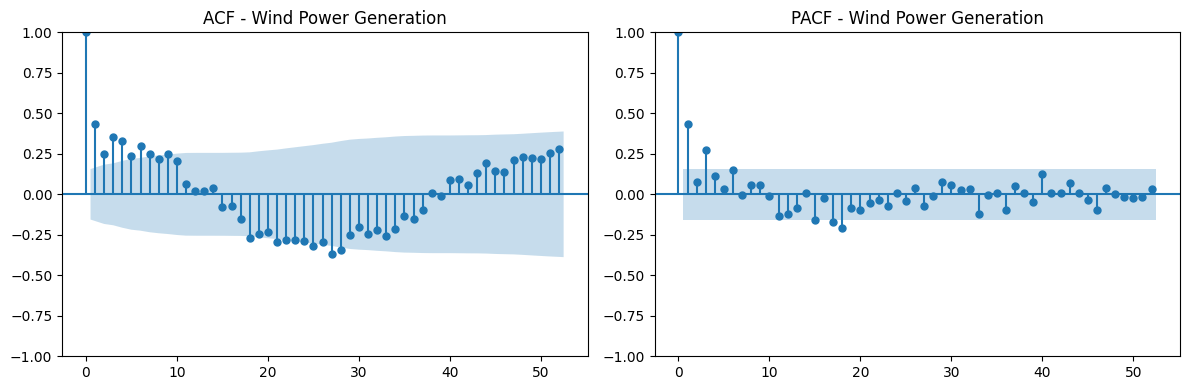

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(weekly_data, ax=axes[0], lags=52)  # Show up to 1 year of lags
axes[0].set_title("ACF - Wind Power Generation")

plot_pacf(weekly_data, ax=axes[1], lags=52)  # Show up to 1 year of lags
axes[1].set_title("PACF - Wind Power Generation")

plt.tight_layout()
plt.show()

****************************************************************************
* Also, the ACF shows slow decay (gradual decrease) over time, Suggests that the data is non-stationary.
****************************************************************************

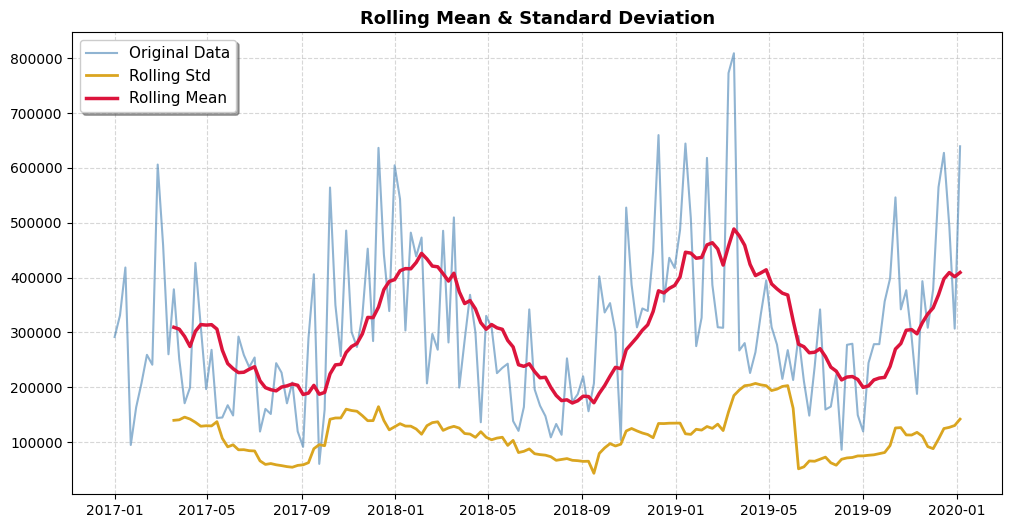

In [ ]:
# Visualize rolling mean and standard deviation
rolling_mean = weekly_data.rolling(window=12).mean()
rolling_std = weekly_data.rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(weekly_data, label='Original Data', color='steelblue', alpha=0.6)
plt.plot(rolling_std, label='Rolling Std', color='goldenrod', linewidth=2)
plt.plot(rolling_mean, label='Rolling Mean', color='crimson', linewidth=2.5)

plt.legend(loc='upper left', fontsize=11, frameon=True, shadow=True)
plt.title('Rolling Mean & Standard Deviation', fontsize=13, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

****************************************************************************
* The rolling mean fluctuates over time, indicating a non-stationary trend. Also, rolling standard deviation fluctuates over time, suggesting some periods of higher variability.
****************************************************************************

In [ ]:
weekly_data.head(3)

,wind_generation_actual
date,
2017-01-01,291760.000000
2017-01-08,331270.714286
2017-01-15,418425.000000


In [ ]:
weekly_data_all = data.resample('W').agg({
    'wind_generation_actual': 'mean',
    'temperature': 'mean',
    'wind_capacity': 'mean',
})
weekly_data_all.head(3)

,wind_generation_actual,temperature,wind_capacity
date,,,
2017-01-01,291760.000000,-2.117000,37149.130000
2017-01-08,331270.714286,-2.840286,37167.065429
2017-01-15,418425.000000,-0.973857,37217.595143


In [ ]:
# Devide data into train and test

train_size = int(len(weekly_data_all) * 0.8)  # 80% training, 20% testing

train = weekly_data_all.iloc[:train_size]  # First 80% for training
test = weekly_data_all.iloc[train_size:]   # Last 20% for testing

y_train = train['wind_generation_actual']
y_test = test['wind_generation_actual']

In [ ]:
train

,wind_generation_actual,temperature,wind_capacity
date,,,
2017-01-01,291760.000000,-2.117000,37149.130000
2017-01-08,331270.714286,-2.840286,37167.065429
2017-01-15,418425.000000,-0.973857,37217.595143
2017-01-22,94920.000000,-5.871000,37281.714429
2017-01-29,163572.571429,-4.351286,37393.916857
...,...,...,...
2019-04-28,394984.428571,12.054000,49266.940429
2019-05-05,309709.000000,8.330571,49293.404714
2019-05-12,277879.285714,8.915429,49310.952286


In [ ]:
# first differencing
data_diff = train['wind_generation_actual'].diff().dropna()

adf_test(data_diff)
print('----------------------')
kpss_test(data_diff)

ADF Statistic: -8.855318787191859
p-value:  1.5335301569484182e-14
Critical Values:
1% -3.486055829282407
5% -2.8859430324074076
10% -2.5797850694444446
We can reject the null hypothesis (H0) --> data is stationary
----------------------
KPSS Statistic: 0.08086990849137188
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


<ipython-input-29-647fc49edd05>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_out = kpss(data,regression='c', nlags='auto', store=True)


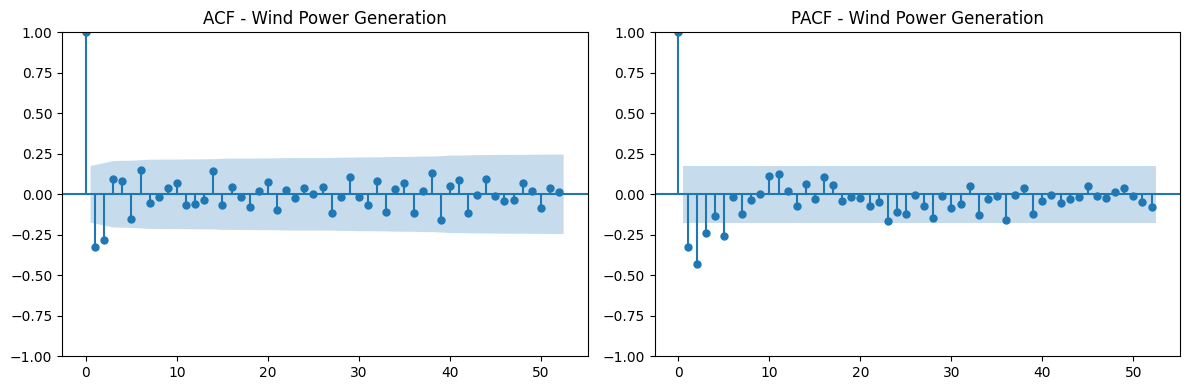

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(data_diff, ax=axes[0], lags=52)  # Show up to 1 year of lags
axes[0].set_title("ACF - Wind Power Generation")

plot_pacf(data_diff, ax=axes[1], lags=52)  # Show up to 1 year of lags
axes[1].set_title("PACF - Wind Power Generation")

plt.tight_layout()
plt.show()

****************************************************************************
First-order differencing successfully removed trend & made data stationary.
****************************************************************************

# **Forecasting**

* **Seasonal Naive**

array([138551.14285714, 120655.28571429, 164126.28571429, 342025.28571429,
       196180.        , 166560.42857143, 147518.28571429, 108850.71428571,
       133197.57142857, 113508.71428571, 252791.71428571, 173512.85714286,
       187479.71428571, 220090.14285714, 156365.71428571, 206831.85714286,
       402215.        , 336471.42857143, 353518.57142857, 301080.        ,
       104075.71428571, 527613.85714286, 387136.71428571, 309315.14285714,
       343791.71428571, 339180.85714286, 446912.        , 659771.        ,
       356104.        , 436076.57142857, 417577.14285714, 486808.28571429])

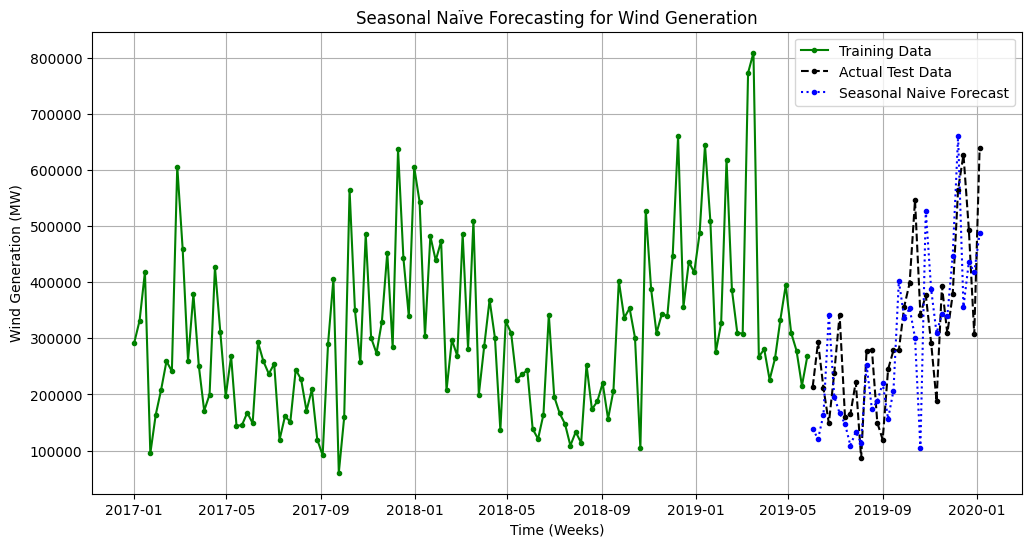

In [ ]:
# seasonal naive
model_SNaive = SeasonalNaive(season_length=52)
model_SNaive = model_SNaive.fit(y_train)

forecast_values_SNaive = model_SNaive.predict(len(y_test))
display(forecast_values_SNaive['mean'])

plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, color='green', marker='.', label='Training Data')
plt.plot(y_test.index, y_test, color='black', linestyle='dashed', marker='.', label='Actual Test Data')
plt.plot(y_test.index, forecast_values_SNaive['mean'], color='blue', marker='.', linestyle='dotted', label='Seasonal Naive Forecast')

plt.xlabel('Time (Weeks)')
plt.ylabel('Wind Generation (MW)')
plt.title('Seasonal Naïve Forecasting for Wind Generation')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
mae = mean_absolute_error(y_test, forecast_values_SNaive['mean'])
rmse = np.sqrt(mean_squared_error(y_test, forecast_values_SNaive['mean']))
mape = np.mean(np.abs((y_test - forecast_values_SNaive['mean']) / y_test)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Mean Absolute Error (MAE): 99808.65625
Root Mean Squared Error (RMSE): 120724.85793816735
Mean Absolute Percentage Error (MAPE): 35.37690818331804%


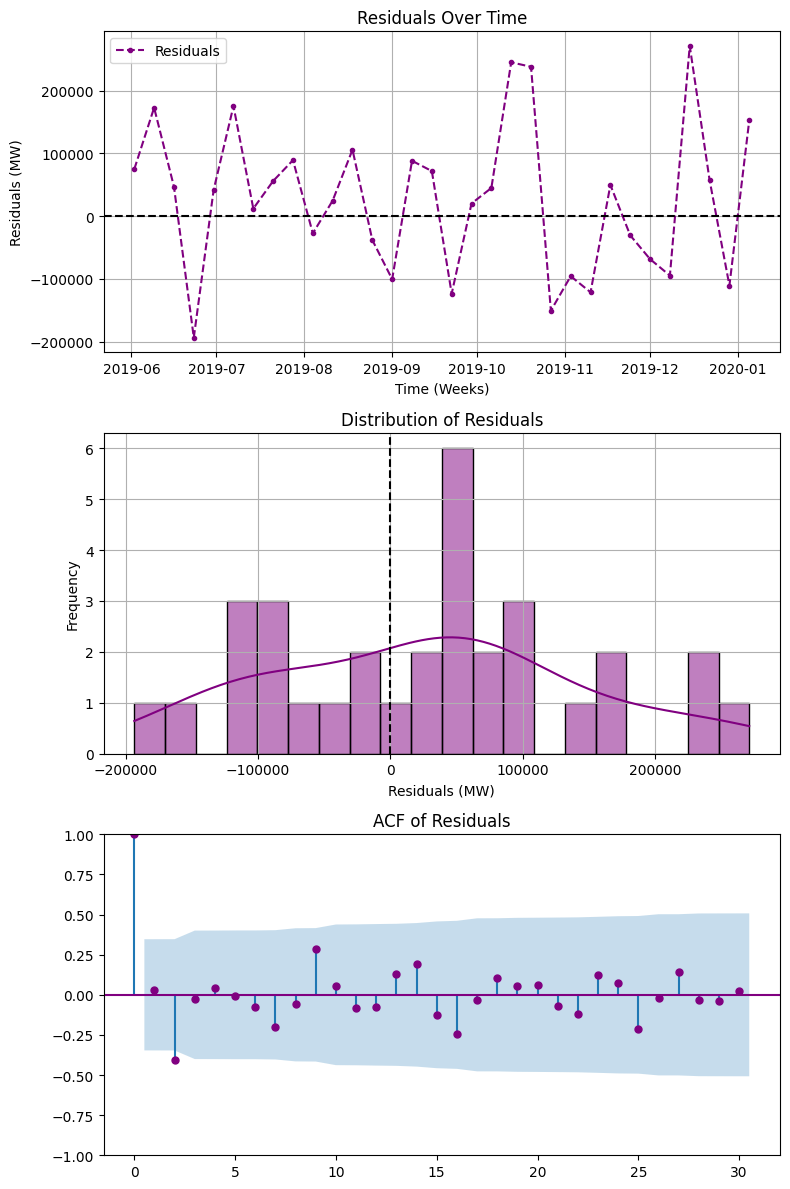

count        32.000000
mean      27644.263393
std      119397.567493
min     -193576.571429
25%      -74985.285714
50%       43290.214286
75%       88495.000000
max      271269.571429
Name: wind_generation_actual, dtype: float64


In [ ]:
residuals = y_test - forecast_values_SNaive['mean']
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Plot residuals over time
axes[0].plot(y_test.index, residuals, color='purple', marker='.', linestyle='dashed', label='Residuals')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1.5)
axes[0].set_xlabel('Time (Weeks)')
axes[0].set_ylabel('Residuals (MW)')
axes[0].set_title('Residuals Over Time')
axes[0].legend()
axes[0].grid(True)

# Histogram of residuals
sns.histplot(residuals, bins=20, kde=True, color='purple', ax=axes[1])
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1.5)
axes[1].set_xlabel('Residuals (MW)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Residuals')
axes[1].grid(True)

# ACF of residuals
plot_acf(residuals, ax=axes[2], lags=30,color='purple')  # Up to 30 lags
axes[2].set_title("ACF of Residuals")

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print summary statistics
print(residuals.describe())

****************************************************************************
* Residuals Over Time: Errors fluctuate around zero but show large spikes, indicating the model struggles with extreme variations.
* Residual Distribution: Not perfectly normal, with some bias and outliers.
* ACF of Residuals: Some correlation remains, meaning the model misses certain patterns.
****************************************************************************

In [ ]:
durbin_watson_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {durbin_watson_stat}")

print('--------------------------')

ljung_box_stat = acorr_ljungbox(residuals, lags=10)
print(ljung_box_stat)

Durbin-Watson Statistic: 1.7984484905077773
--------------------------
      lb_stat  lb_pvalue
1    0.033395   0.855000
2    6.078253   0.047877
3    6.106096   0.106561
4    6.186372   0.185656
5    6.190722   0.288101
6    6.425088   0.377292
7    8.199395   0.315340
8    8.353300   0.399741
9   12.140073   0.205527
10  12.275502   0.267041


****************************************************************************
* Durbin-Watson Statistic is close to 2, which indicates little autocorrelation in residuals.
* In the ljung_box test, most p-values above 0.1, meaning no strong autocorrelations.
* Therefore, the Seasonal Naïve model captures most patterns, but not all.
****************************************************************************

* **ETS**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


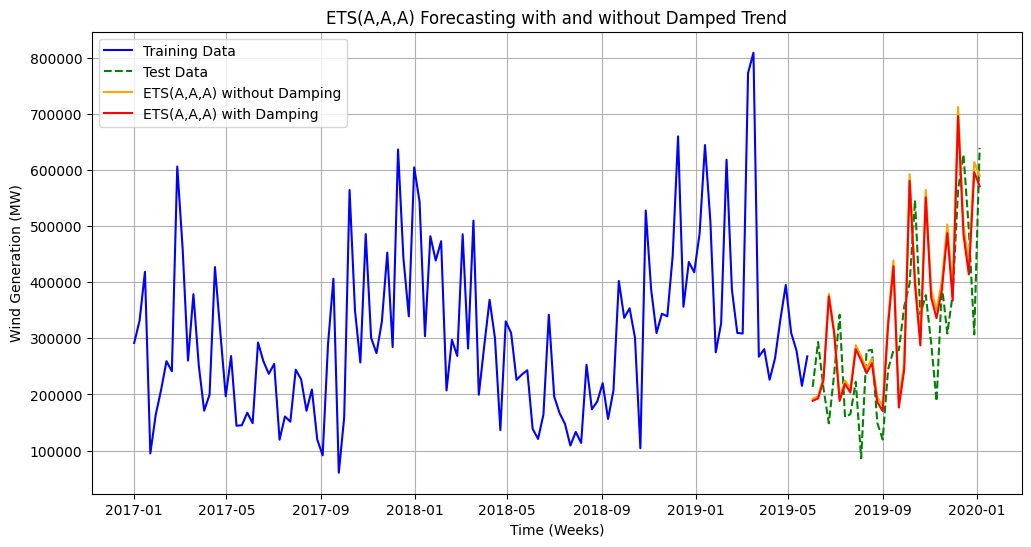

Model without Damping:
                         ExponentialSmoothing Model Results                        
Dep. Variable:     wind_generation_actual   No. Observations:                  126
Model:               ExponentialSmoothing   SSE                  1930401107352.402
Optimized:                           True   AIC                           3067.011
Trend:                           Additive   BIC                           3225.843
Seasonal:                        Additive   AICC                          3169.160
Seasonal Periods:                      52   Date:                 Mon, 17 Feb 2025
Box-Cox:                            False   Time:                         17:35:35
Box-Cox Coeff.:                      None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0403571                alpha     

In [ ]:
# Fit ETS(A, A, A) model without damping
model_no_damped = ExponentialSmoothing(
    y_train,
    trend='add',      # Additive trend
    seasonal='add',   # Additive seasonality
    seasonal_periods=52  # Weekly seasonality (1-year cycle)
).fit()

# Fit ETS(A, A, A) model with damping
model_damped = ExponentialSmoothing(
    y_train,
    trend='add',
    seasonal='add',
    seasonal_periods=52,
    damped_trend=True  # Apply damping to the trend
).fit()


forecast_no_damped = model_no_damped.forecast(len(y_test))
forecast_damped = model_damped.forecast(len(y_test))

plt.figure(figsize=(12, 6))

plt.plot(y_train.index, y_train, label='Training Data', color='blue')
plt.plot(y_test.index, y_test, label='Test Data', color='green', linestyle='dashed')

plt.plot(y_test.index, forecast_no_damped, label='ETS(A,A,A) without Damping', color='orange')
plt.plot(y_test.index, forecast_damped, label='ETS(A,A,A) with Damping', color='red')

plt.title('ETS(A,A,A) Forecasting with and without Damped Trend')
plt.xlabel('Time (Weeks)')
plt.ylabel('Wind Generation (MW)')
plt.legend()
plt.grid()
plt.show()


print("Model without Damping:\n", model_no_damped.summary())
print("\nModel with Damping:\n", model_damped.summary())


In [ ]:
# Evaluate Model Performance (MAE, RMSE, MAPE)
mae_no_damped = mean_absolute_error(y_test, forecast_no_damped)
rmse_no_damped = np.sqrt(mean_squared_error(y_test, forecast_no_damped))
mape_no_damped = np.mean(np.abs((y_test - forecast_no_damped) / y_test)) * 100

mae_damped = mean_absolute_error(y_test, forecast_damped)
rmse_damped = np.sqrt(mean_squared_error(y_test, forecast_damped))
mape_damped = np.mean(np.abs((y_test - forecast_damped) / y_test)) * 100

# Extract AIC values
aic_no_damped = model_no_damped.aic
aic_damped = model_damped.aic


performance_comparison = pd.DataFrame({
    "Model": ["ETS No Damping", "ETS Damped"],
    "MAE": [mae_no_damped, mae_damped],
    "RMSE": [rmse_no_damped, rmse_damped],
    "MAPE": [mape_no_damped, mape_damped],
    "AIC": [aic_no_damped, aic_damped]
})

print(performance_comparison)

            Model            MAE           RMSE       MAPE          AIC
0  ETS No Damping  101866.330402  124801.727295  41.589634  3067.010844
1      ETS Damped  100310.856029  120997.472751  40.093526  3068.171986


****************************************************************************
* Damped Model is slightly better in MAE, RMSE, and MAPE, meaning it makes fewer errors in predicting wind generation.
* No Damping Model has a slightly better AIC, meaning it provides a slightly better model fit in terms of complexity.
* Seasonal Naïve performs better than ETS models because it has lower MAE, RMSE, and MAPE, meaning its forecasts are more accurate.
****************************************************************************

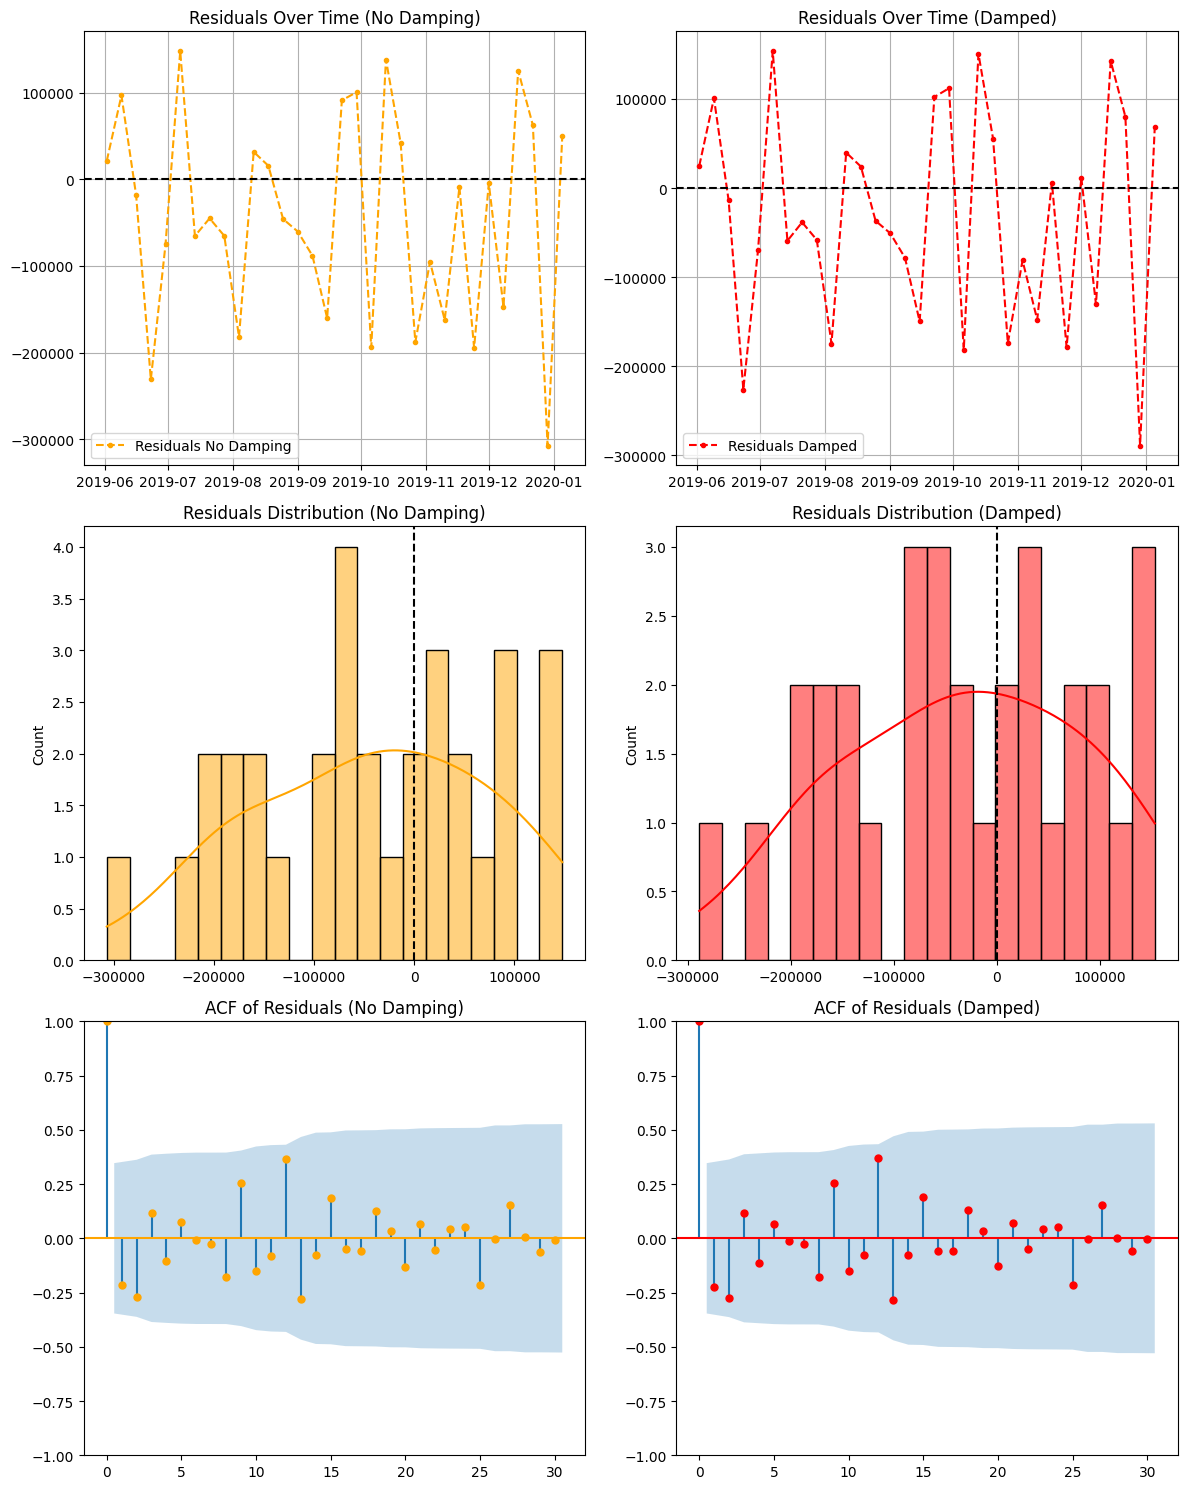

In [ ]:
# Compute residuals
residuals_no_damped = y_test - forecast_no_damped
residuals_damped = y_test - forecast_damped

fig, axes = plt.subplots(3, 2, figsize=(12, 15))

axes[0, 0].plot(y_test.index, residuals_no_damped, color='orange', marker='.', linestyle='dashed', label='Residuals No Damping')
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1.5)
axes[0, 0].set_title('Residuals Over Time (No Damping)')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(y_test.index, residuals_damped, color='red', marker='.', linestyle='dashed', label='Residuals Damped')
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=1.5)
axes[0, 1].set_title('Residuals Over Time (Damped)')
axes[0, 1].legend()
axes[0, 1].grid(True)


sns.histplot(residuals_no_damped, bins=20, kde=True, color='orange', ax=axes[1, 0])
axes[1, 0].axvline(x=0, color='black', linestyle='--', linewidth=1.5)
axes[1, 0].set_title('Residuals Distribution (No Damping)')

sns.histplot(residuals_damped, bins=20, kde=True, color='red', ax=axes[1, 1])
axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=1.5)
axes[1, 1].set_title('Residuals Distribution (Damped)')


plot_acf(residuals_no_damped, ax=axes[2, 0], lags=30, color='orange')
axes[2, 0].set_title("ACF of Residuals (No Damping)")

plot_acf(residuals_damped, ax=axes[2, 1], lags=30, color='red')
axes[2, 1].set_title("ACF of Residuals (Damped)")

plt.tight_layout()
plt.show()


****************************************************************************
* Neither model fully eliminates patterns, meaning the ETS models may not be the best fit.
* Both histograms are not perfectly normal
* Both models leave some seasonality uncaptured, meaning a more complex model (SARIMA) may be needed.
****************************************************************************

* **SARIMA**

****************************************************************************
As AutoARIMA finds the best (p, d, q, P, D, Q, m) automatically, we will start with it.

However, the high seasonal values (m=30 and m=52) caused memory issues, so we will resample to monthly frequency (m=12).
****************************************************************************

In [ ]:
monthly_data.head(3)

,wind_generation_actual
date,
2017-01-31,252004.774194
2017-02-28,353563.964286
2017-03-31,299794.258065


In [ ]:
monthly_data_all = data.resample('M').agg({
    'wind_generation_actual': 'mean',
    'temperature': 'mean',
    'wind_capacity': 'mean',
})
monthly_data_all.head(3)

<ipython-input-45-04f87ee273d8>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data_all = data.resample('M').agg({


,wind_generation_actual,temperature,wind_capacity
date,,,
2017-01-31,252004.774194,-3.228097,37272.973323
2017-02-28,353563.964286,2.081500,37634.125036
2017-03-31,299794.258065,6.628032,38007.849452


<ipython-input-46-c5fa639987ce>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data['wind_generation_actual'].resample('M').mean()


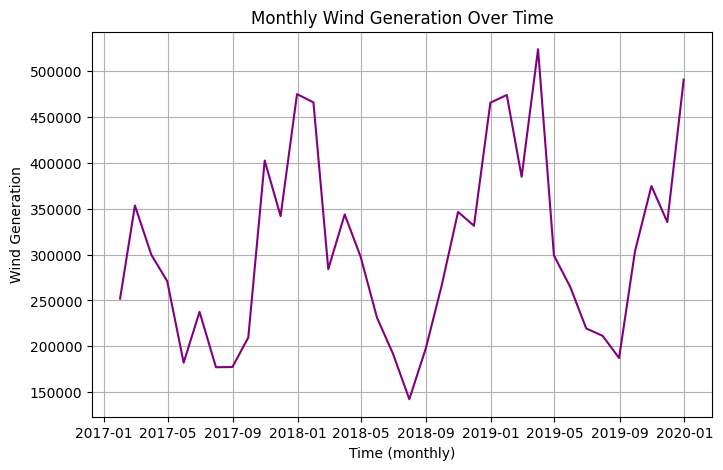

In [ ]:
plt.figure(figsize=(8,5))
monthly_data = data['wind_generation_actual'].resample('M').mean()
plt.plot(monthly_data, color='purple')
plt.xlabel("Time (monthly)")
plt.ylabel("Wind Generation")
plt.title("Monthly Wind Generation Over Time")
plt.grid(True)
plt.show()

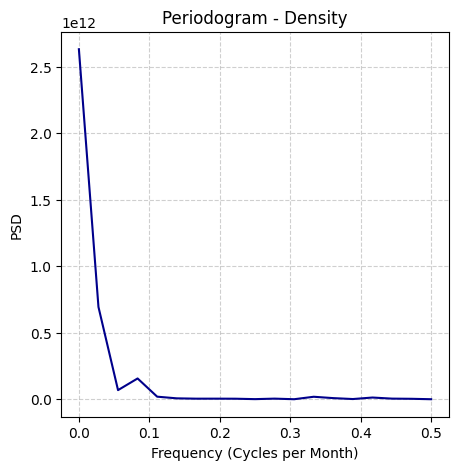

In [ ]:
Fs = 1
window_type = 'triang'

# Compute PSD using Periodogram
f_per_density, Pxx_per_density = signal.periodogram(monthly_data, Fs, detrend=False, window=window_type,
                                                    nfft=None, return_onesided=True, scaling='density')

fig1, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(f_per_density, Pxx_per_density, color='darkblue', linestyle='-')
ax.set_title('Periodogram - Density', fontsize=12)
ax.set(xlabel='Frequency (Cycles per Month)', ylabel='PSD')
ax.grid(True, linestyle='--', alpha=0.6)

****************************************************************************
Plots confirms a seasonal trend in wind energy production.
****************************************************************************

In [ ]:
# ADF test
def adf_test(data):
  adf_test = adfuller(data,autolag='AIC')
  print('ADF Statistic:', adf_test[0])
  print('p-value: ', adf_test[1])
  print('Critical Values:')
  for key, value in adf_test[4].items():
      print(key, value)

  if adf_test[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is non-stationary')

adf_test(monthly_data)

ADF Statistic: -3.1734768475841912
p-value:  0.02157219678153532
Critical Values:
1% -3.6996079738860943
5% -2.9764303469999494
10% -2.627601001371742
We can reject the null hypothesis (H0) --> data is stationary


In [ ]:
# KPSS test
def kpss_test(data):
  kpss_out = kpss(data,regression='c', nlags='auto', store=True)
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is not trend stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')

kpss_test(monthly_data)

KPSS Statistic: 0.12166292810755096
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


<ipython-input-49-92ca52f485ee>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_out = kpss(data,regression='c', nlags='auto', store=True)


In [ ]:
train_size1 = int(len(monthly_data_all) * 0.8)

train1 = monthly_data_all.iloc[:train_size1]
test1 = monthly_data_all.iloc[train_size1:]

y_train1 = train1['wind_generation_actual']
y_test1 = test1['wind_generation_actual']

In [ ]:
auto_sarima = auto_arima(y_train1, start_p=0, start_q=0, d=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, start_Q=0,max_P = 5, max_Q = 5, D = 1, seasonal=True,
                           trace=True, information_criterion='aic',
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=409.385, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=407.412, Time=0.35 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=405.439, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=412.658, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=404.766, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=405.399, Time=0.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=406.915, Time=2.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=2.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=405.139, Time=0.82 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=408.026, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(0,0,1)(0,1,0)[12]             : AIC=403.125, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,0)[12]             : AIC=404.614, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[12]             : AIC=404.680, Time=0.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,1)[12]             : AIC=inf, Time=1.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,0)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,2)(0,1,0)[12]             : AIC=404.520, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=406.286, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,1,0)[12]             : AIC=403.456, Time=0.22 sec

Best model:  ARIMA(0,0,1)(0,1,0)[12]          
Total fit time: 10.551 seconds


In [ ]:
print(auto_sarima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   28
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood                -199.562
Date:                             Mon, 17 Feb 2025   AIC                            403.125
Time:                                     17:38:47   BIC                            404.670
Sample:                                 01-31-2017   HQIC                           403.204
                                      - 04-30-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5423      0.182      2.975      0.003       0.185       0.900
sigma2      3.975e+09   6.4

                                      SARIMAX Results                                      
Dep. Variable:              wind_generation_actual   No. Observations:                   28
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood                -199.383
Date:                             Mon, 17 Feb 2025   AIC                            404.766
Time:                                     17:38:56   BIC                            407.084
Sample:                                 01-31-2017   HQIC                           404.885
                                      - 04-30-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.474e+04   2.36e+04      0.625      0.532   -3.15e+04     6.1e+04
ma.L1          0.5178      

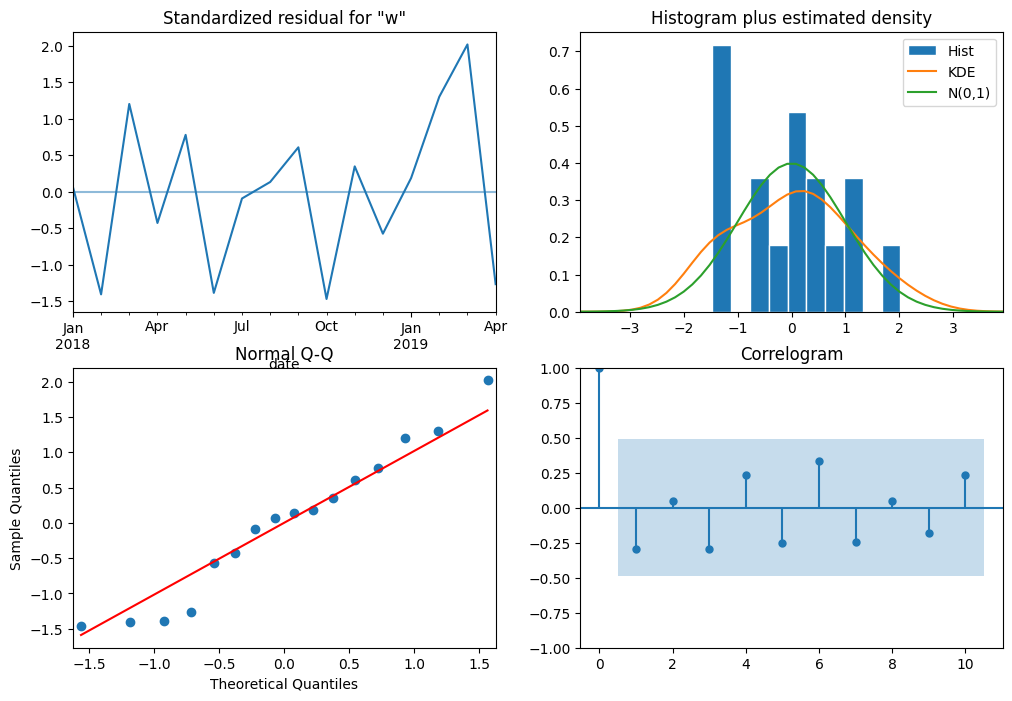

In [ ]:
# Best model:  ARIMA(0,0,1)(0,1,0)[12]
[p,d,q] = [0,0,1]
[P,D,Q,S] = [0,1,0,12]
model_SARIMA_auto = SARIMAX(y_train1,
                       order=(p,d,q),
                       seasonal_order=(P,D,Q,S), trend='c')
result_SARIMA_auto = model_SARIMA_auto.fit()

print(result_SARIMA_auto.summary())
result_SARIMA_auto.plot_diagnostics(figsize=(12, 8));

****************************************************************************


*   Ljung-Box Test: p-value = 0.19 > 0.05, Fail to reject H₀ (Residuals are random), meaning no significant autocorrelation.
*   Jarque-Bera Test: p-value = 0.78 > 0.05, Fail to reject H₀ (Residuals are normally distributed), meaning residuals are close to normal.
*    Heteroskedasticity Test: p-value = 0.52 > 0.05, Fail to reject H₀ (Residuals have constant variance), meaning variance does not change significantly.

****************************************************************************

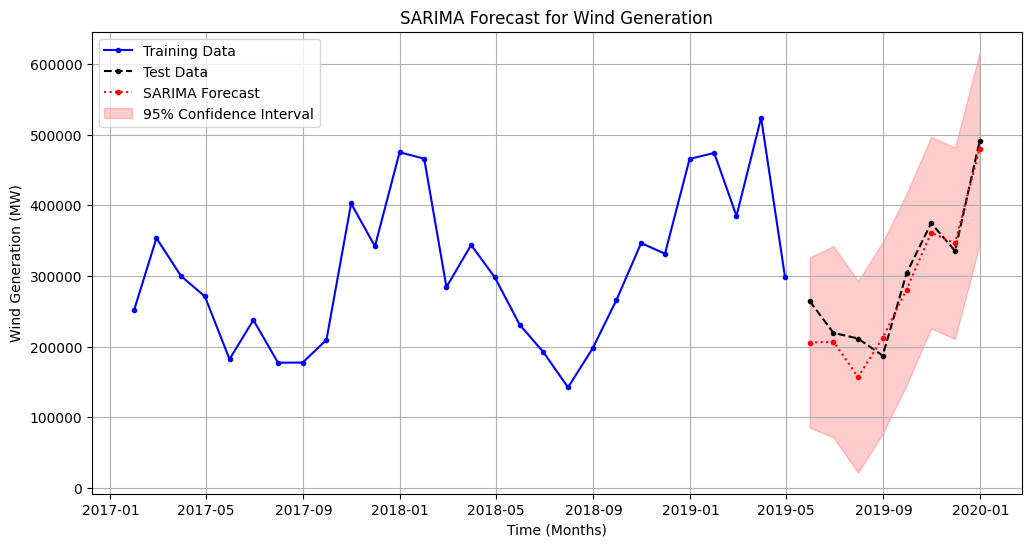

--------------------------------
Mean Absolute Error (MAE): 26030.757985531673
Root Mean Squared Error (RMSE): 31850.95847966531


In [ ]:

forecast_horizon = len(y_test1)

sarima_forecast_auto = result_SARIMA_auto.get_forecast(steps=forecast_horizon)
forecast_mean = sarima_forecast_auto.predicted_mean

confidence_intervals = sarima_forecast_auto.conf_int()


plt.figure(figsize=(12, 6))

plt.plot(y_train1.index, y_train1, label="Training Data", color='blue', marker='.')
plt.plot(y_test1.index, y_test1, label="Test Data", color='black', linestyle='dashed', marker='.')

plt.plot(y_test1.index, forecast_mean, label="SARIMA Forecast", color='red', linestyle='dotted', marker='.')

plt.fill_between(y_test1.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1],
                 color='red', alpha=0.2, label="95% Confidence Interval")

plt.xlabel('Time (Months)')
plt.ylabel('Wind Generation (MW)')
plt.title('SARIMA Forecast for Wind Generation')
plt.legend()
plt.grid(True)
plt.show()

print('--------------------------------')
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test1, forecast_mean)}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test1, forecast_mean))}")

****************************************************************************
* Forecast follows the general trend of the test data.
* Seasonal patterns are somewhat captured.
* Confidence Interval widens as time progresses, meaning uncertainty increases in long-term predictions.
****************************************************************************

* **SARIMAX**

                                      SARIMAX Results                                      
Dep. Variable:              wind_generation_actual   No. Observations:                   28
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood                -198.026
Date:                             Mon, 17 Feb 2025   AIC                            402.052
Time:                                     17:58:54   BIC                            404.369
Sample:                                 01-31-2017   HQIC                           402.170
                                      - 04-30-2019                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature  1.611e+04   3431.007      4.695      0.000    9383.895    2.28e+04
ma.L1           0.1981  

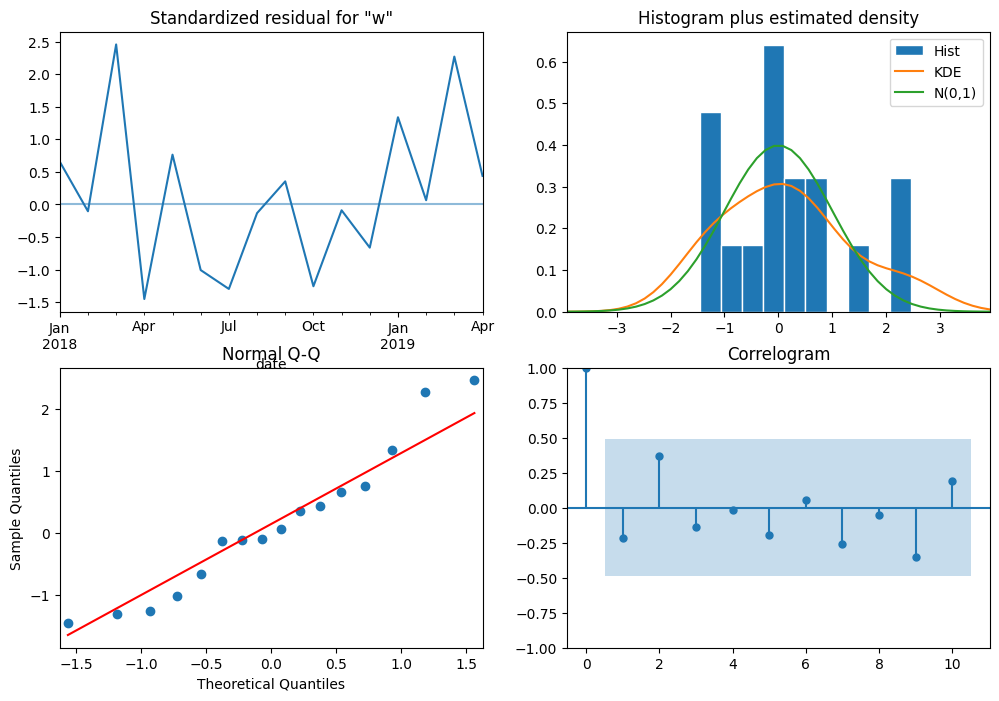

In [ ]:
# Since temperature is moderately correlated with wind generation (Based on the correlation matrix), it might improve forecasting in SARIMAX.

# Fit SARIMAX Model
sarimax_model = SARIMAX(y_train1,
                        exog=train1[['temperature']],
                        order=(0,0,1),
                        seasonal_order=(0,1,0,12))
sarimax_result = sarimax_model.fit()
print(sarimax_result.summary())
sarimax_result.plot_diagnostics(figsize=(12, 8));

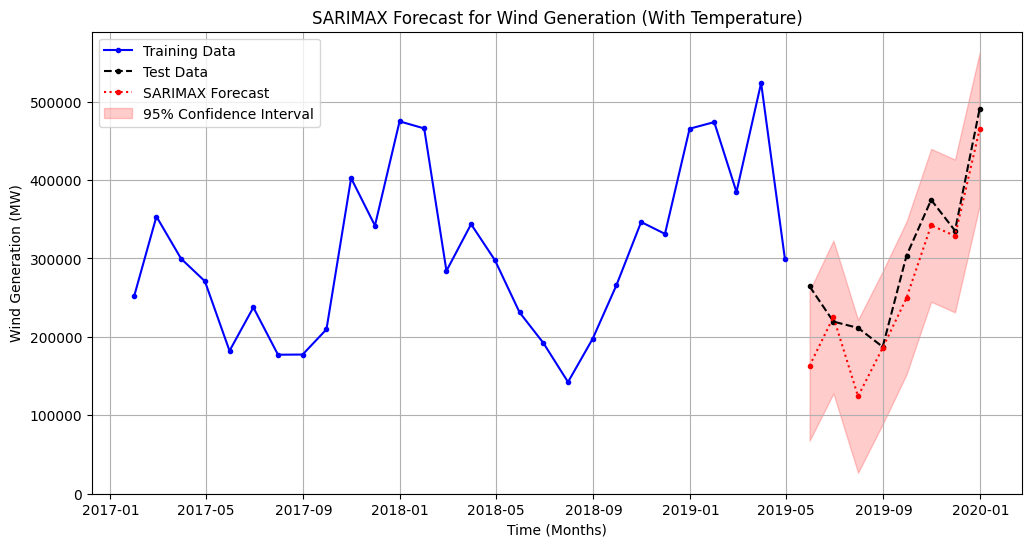

In [ ]:
sarimax_forecast = sarimax_result.get_forecast(steps=len(y_test1), exog=test1[['temperature']])
forecast_mean_sarimax = sarimax_forecast.predicted_mean

confidence_intervals_sarimax = sarimax_forecast.conf_int()

# Plot the forecast results
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(y_train1.index, y_train1, label="Training Data", color='blue', marker='.')
plt.plot(y_test1.index, y_test1, label="Test Data", color='black', linestyle='dashed', marker='.')

# Plot SARIMAX forecast
plt.plot(y_test1.index, forecast_mean_sarimax, label="SARIMAX Forecast", color='red', linestyle='dotted', marker='.')

# Plot confidence intervals
plt.fill_between(y_test1.index, confidence_intervals_sarimax.iloc[:, 0], confidence_intervals_sarimax.iloc[:, 1],
                 color='red', alpha=0.2, label="95% Confidence Interval")

# Labels and legend
plt.xlabel('Time (Months)')
plt.ylabel('Wind Generation (MW)')
plt.title('SARIMAX Forecast for Wind Generation (With Temperature)')
plt.legend()
plt.grid(True)
plt.show()

****************************************************************************
* AIC & BIC are slightly lower than SARIMA → This suggests SARIMAX performs slightly better than SARIMA.
* Ljung-Box Test (Q=0.89, p=0.35):	No significant autocorrelation in residuals
Jarque-Bera Test (JB=0.85, p=0.65):	Residuals follow a normal distribution
Heteroskedasticity (H=0.83, p=0.84):	No strong variance change (stationary variance)
****************************************************************************

In [ ]:
# SARIMA Forecast Errors
sarima_mae = mean_absolute_error(y_test1, forecast_mean)
sarima_rmse = np.sqrt(mean_squared_error(y_test1, forecast_mean))

# SARIMAX Forecast Errors
sarimax_mae = mean_absolute_error(y_test1, forecast_mean_sarimax)
sarimax_rmse = np.sqrt(mean_squared_error(y_test1, forecast_mean_sarimax))

comparison_df = pd.DataFrame({
    'Model': ['SARIMA', 'SARIMAX'],
    'MAE': [sarima_mae, sarimax_mae],
    'RMSE': [sarima_rmse, sarimax_rmse]
})
print(comparison_df)

     Model           MAE          RMSE
0   SARIMA  26030.757986  31850.958480
1  SARIMAX  39350.122685  53175.560328


****************************************************************************
Final Comparison:

* SARIMA performs better than SARIMAX in both MAE and RMSE.
* SARIMAX has a higher error, meaning adding temperature did NOT improve the forecast.
****************************************************************************

****************************************************************************
As weekly models (ETS & Seasonal Naïve) predict weekly wind generation, and monthly models (SARIMA & SARIMAX) predict monthly wind generation directly comparing them is not valid. So, i want to do the ETS model again for monthly frequency.
****************************************************************************

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


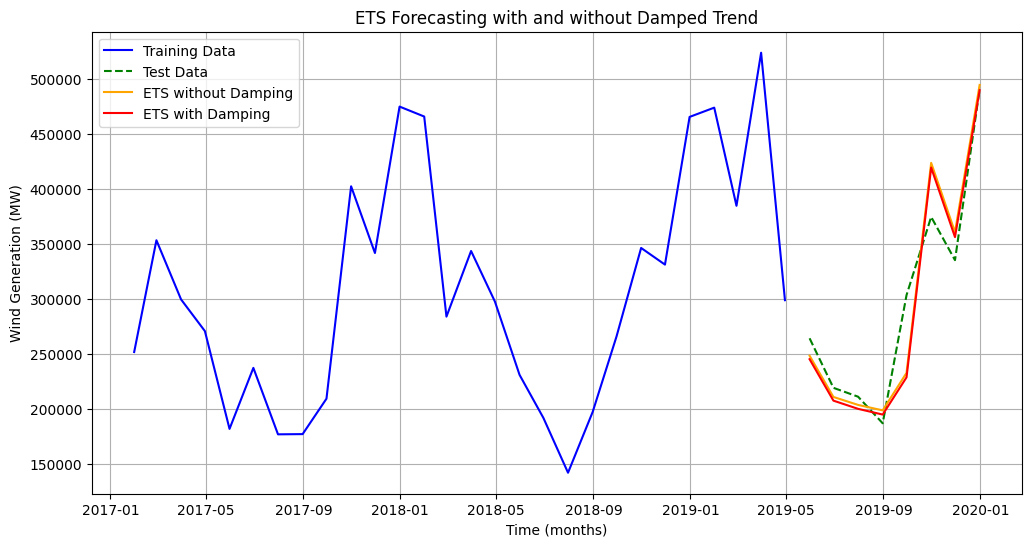

Model without Damping:
                         ExponentialSmoothing Model Results                        
Dep. Variable:     wind_generation_actual   No. Observations:                   28
Model:               ExponentialSmoothing   SSE                   100944616497.314
Optimized:                           True   AIC                            648.158
Trend:                           Additive   BIC                            669.473
Seasonal:                        Additive   AICC                           724.158
Seasonal Periods:                      12   Date:                 Mon, 17 Feb 2025
Box-Cox:                            False   Time:                         18:01:04
Box-Cox Coeff.:                      None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0050000                alpha     

In [ ]:
# Fit ETS(A, A, A) model without damping
model_no_damped = ExponentialSmoothing(
    y_train1,
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

# Fit ETS(A, A, A) model with damping
model_damped = ExponentialSmoothing(
    y_train1,
    trend='add',
    seasonal='add',
    seasonal_periods=12,
    damped_trend=True
).fit()


forecast_no_damped = model_no_damped.forecast(len(y_test1))
forecast_damped = model_damped.forecast(len(y_test1))

plt.figure(figsize=(12, 6))

plt.plot(y_train1.index, y_train1, label='Training Data', color='blue')
plt.plot(y_test1.index, y_test1, label='Test Data', color='green', linestyle='dashed')

plt.plot(y_test1.index, forecast_no_damped, label='ETS without Damping', color='orange')
plt.plot(y_test1.index, forecast_damped, label='ETS with Damping', color='red')

plt.title('ETS Forecasting with and without Damped Trend')
plt.xlabel('Time (months)')
plt.ylabel('Wind Generation (MW)')
plt.legend()
plt.grid()
plt.show()


print("Model without Damping:\n", model_no_damped.summary())
print("\nModel with Damping:\n", model_damped.summary())

In [ ]:
# Evaluate Model Performance (MAE, RMSE, MAPE)
mae_no_damped = mean_absolute_error(y_test1, forecast_no_damped)
rmse_no_damped = np.sqrt(mean_squared_error(y_test1, forecast_no_damped))
mape_no_damped = np.mean(np.abs((y_test1 - forecast_no_damped) / y_test1)) * 100

mae_damped = mean_absolute_error(y_test1, forecast_damped)
rmse_damped = np.sqrt(mean_squared_error(y_test1, forecast_damped))
mape_damped = np.mean(np.abs((y_test1 - forecast_damped) / y_test1)) * 100

# Extract AIC values
aic_no_damped = model_no_damped.aic
aic_damped = model_damped.aic


performance_comparison = pd.DataFrame({
    "Model": ["ETS No Damping", "ETS Damped"],
    "MAE": [mae_no_damped, mae_damped],
    "RMSE": [rmse_no_damped, rmse_damped],
    "MAPE": [mape_no_damped, mape_damped],
    "AIC": [aic_no_damped, aic_damped]
})

print(performance_comparison)

            Model           MAE          RMSE      MAPE         AIC
0  ETS No Damping  24047.118258  32749.400049  8.037815  648.157734
1      ETS Damped  23881.809904  32994.736114  8.117849  650.403645


****************************************************************************
For comparing SARIMA and ETS models, we can say that:
* SARIMA has the lower AIC (403.12) than ETS (650.40).
* SARIMA has the lower RMSE (31,850.96) than ETS (32994.736114)
* ETS has the lowest MAE than SARIMA (26,030.76).
****************************************************************************

# ---------------------------------------------------------------------------------------